# Multimodal House Price Valuation — Explainability & Economic Insight

This notebook focuses on explaining *why* our multimodal model makes certain price predictions.

Goals:
- Visually interpret satellite-image influence using Grad-CAM
- Understand whether the model focuses on economically meaningful regions
- Validate that image signals complement tabular features
- Ensure the model does not rely on random or spurious visual patterns

This notebook is **for explainability only**, not for improving metrics.


In [25]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from PIL import Image
import cv2

plt.style.use("seaborn-v0_8")


In [26]:
TRAIN_PATH = "data/processed/train_final.csv"
META_PATH  = "data/satellite/image_metadata.csv"

train_df = pd.read_csv(TRAIN_PATH)
meta_df  = pd.read_csv(META_PATH)

meta_df = meta_df[meta_df["status"].isin(["ok", "cached"])]

print("Train:", train_df.shape)
print("Metadata:", meta_df.shape)


Train: (13334, 25)
Metadata: (16209, 3)


In [27]:
train_img_df = train_df.merge(
    meta_df[["id", "image_path"]],
    on="id",
    how="inner"
)

print("Train with images:", train_img_df.shape)
train_img_df.head()


Train with images: (13494, 26)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,image_path_x,image_exists,log_price,spatial_bin,image_path_y
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,98055,47.4362,-122.187,1660,9240,/Users/khushirawat/Desktop/CDC/data/images/0.png,True,12.501142,2372_-6109,data/images/0.png
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,98031,47.4034,-122.187,1720,3605,/Users/khushirawat/Desktop/CDC/data/images/1.png,True,12.409018,2370_-6109,data/images/1.png
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,98003,47.2704,-122.313,1870,7455,/Users/khushirawat/Desktop/CDC/data/images/2.png,True,12.206078,2364_-6116,data/images/2.png
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,98027,47.5321,-122.073,1240,750,/Users/khushirawat/Desktop/CDC/data/images/3.png,True,12.772806,2377_-6104,data/images/3.png
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,98042,47.3715,-122.074,1590,8071,/Users/khushirawat/Desktop/CDC/data/images/4.png,True,12.354497,2369_-6104,data/images/4.png


In [38]:
# ===============================
# FIX image_path column (IMPORTANT)
# ===============================

# Handle merge-created columns
if "image_path_y" in train_img_df.columns:
    train_img_df["image_path"] = train_img_df["image_path_y"]
elif "image_path_x" in train_img_df.columns:
    train_img_df["image_path"] = train_img_df["image_path_x"]

# Drop confusing columns if present
train_img_df = train_img_df.drop(
    columns=[c for c in ["image_path_x", "image_path_y"] if c in train_img_df.columns]
)

# Final sanity check
assert "image_path" in train_img_df.columns
print("✅ image_path column fixed")
train_img_df[["id", "image_path"]].head()


✅ image_path column fixed


,id,image_path
0,9117000170,data/images/0.png
1,6700390210,data/images/1.png
2,7212660540,data/images/2.png
3,8562780200,data/images/3.png
4,7760400350,data/images/4.png


In [39]:
IMG_SIZE = 224

image_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [52]:
class ImagePriceDataset(Dataset):
    def __init__(self, df, id_col, target_col, transform=None):
        self.df = df.reset_index(drop=True)
        self.id_col = id_col
        self.target_col = target_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        target = float(row[self.target_col])
        sample_id = row[self.id_col]

        return img, target, sample_id


In [55]:
from torchvision import transforms

IMG_SIZE = 224

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [56]:
from torch.utils.data import DataLoader

train_dataset = ImagePriceDataset(
    train_img_df,
    id_col=ID_COL,
    target_col=TARGET_COL,
    transform=img_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

print("Train dataset size:", len(train_dataset))


Train dataset size: 13494


In [57]:
import torch
from torch import nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for p in base_resnet.parameters():
    p.requires_grad = False

feature_dim = base_resnet.fc.in_features
base_resnet.fc = nn.Identity()

class ResNetRegressor(nn.Module):
    def __init__(self, backbone, feature_dim):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Linear(feature_dim, 1)

    def forward(self, x):
        feats = self.backbone(x)
        out = self.head(feats)
        return out.squeeze(-1), feats

model = ResNetRegressor(base_resnet, feature_dim).to(device)


In [58]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)

def train_image_regressor(epochs=3):
    model.train()
    for e in range(epochs):
        losses = []
        for imgs, targets, _ in train_loader:
            imgs = imgs.to(device)
            targets = targets.to(device).float()

            optimizer.zero_grad()
            preds, _ = model(imgs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print(f"Epoch {e+1}/{epochs} | MSE: {np.mean(losses):.4f}")

train_image_regressor(epochs=3)


Epoch 1/3 | MSE: 8.2616
Epoch 2/3 | MSE: 1.7728
Epoch 3/3 | MSE: 1.3787


In [71]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x):
        self.model.eval()
        x = x.requires_grad_(True)

        preds, _ = self.model(x)
        self.model.zero_grad()
        preds.mean().backward()

        if self.gradients is None or self.activations is None:
            raise RuntimeError("GradCAM failed: no gradients captured")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [72]:
cam = GradCAM(
    model=model,
    target_layer=model.backbone.layer4[-1]  # LAST CONV BLOCK
)
def show_gradcam(idx):
    img, _, _ = train_dataset[idx]

    x = img.unsqueeze(0).to(device)
    x.requires_grad_()   # 🔥 REQUIRED

    cam_map = cam.generate(x)
    cam_map = cv2.resize(cam_map, (IMG_SIZE, IMG_SIZE))

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_map),
        cv2.COLORMAP_JET
    )
    heatmap = heatmap[..., ::-1] / 255.0

    overlay = 0.6 * img_np + 0.4 * heatmap

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()


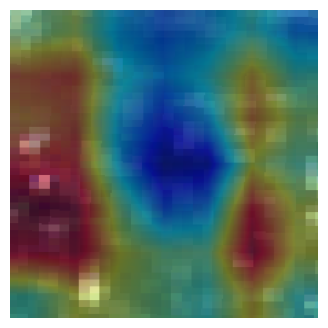

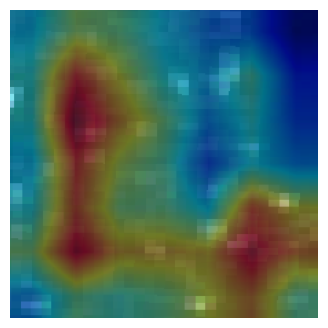

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008304829709231853..1.0000000238418578].


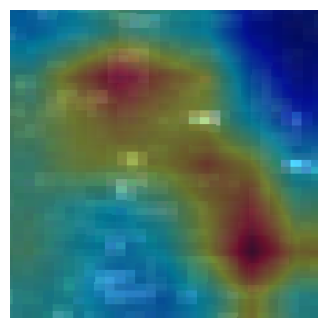

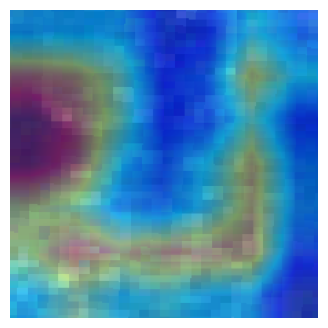

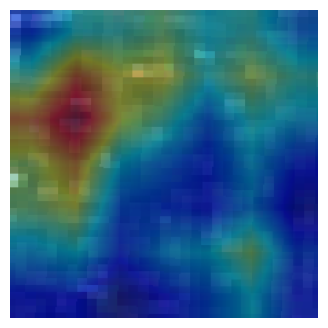

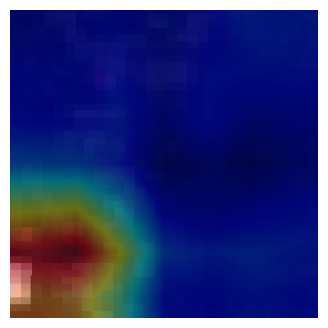

In [73]:
# High price
high_idx = train_img_df["log_price"].nlargest(3).index
for idx in high_idx:
    show_gradcam(idx)

# Low price
low_idx = train_img_df["log_price"].nsmallest(3).index
for idx in low_idx:
    show_gradcam(idx)


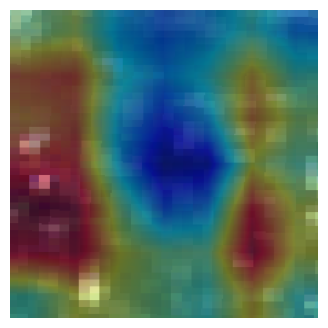

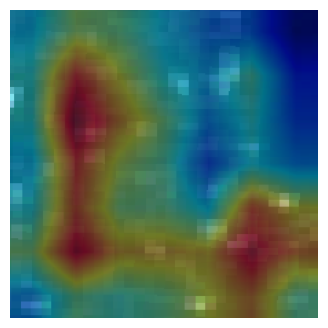

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008304829709231853..1.0000000238418578].


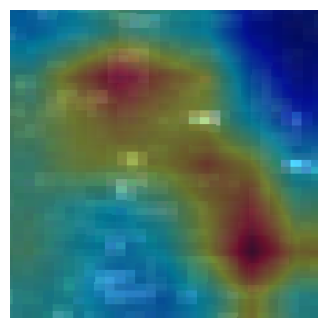

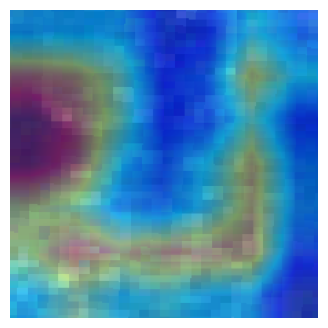

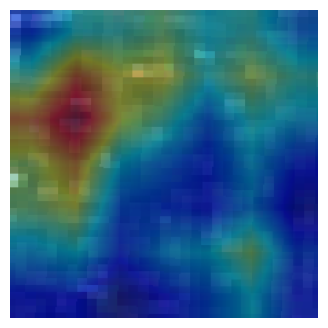

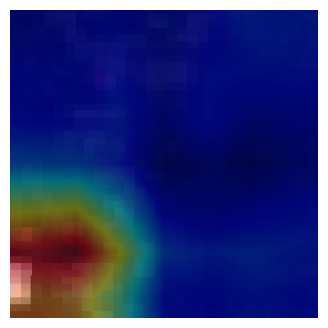

In [74]:
cam = GradCAM(
    model=model,
    target_layer=model.backbone.layer4[-1]  # ResNet18 last conv block
)
def show_gradcam(idx):
    img, _, _ = train_dataset[idx]

    x = img.unsqueeze(0).to(device)
    x.requires_grad_()

    cam_map = cam.generate(x)
    cam_map = cv2.resize(cam_map, (IMG_SIZE, IMG_SIZE))

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_map),
        cv2.COLORMAP_JET
    )
    heatmap = heatmap[..., ::-1] / 255.0

    overlay = 0.6 * img_np + 0.4 * heatmap

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()
# High price
high_idx = train_img_df["log_price"].nlargest(3).index
for idx in high_idx:
    show_gradcam(idx)

# Low price
low_idx = train_img_df["log_price"].nsmallest(3).index
for idx in low_idx:
    show_gradcam(idx)
